In [7]:
#  mount google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
dataset_path = '/content/drive/MyDrive/live in lab harini and co/paddy.zip'

In [9]:
!unzip '/content/drive/MyDrive/live in lab harini and co/paddy.zip' -d '/content/dataset'

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a larger size
    transforms.RandomCrop((224, 224)),  # Randomly crop to ResNet input size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter augmentation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

In [12]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
train_dataset = ImageFolder(root='/content/dataset/train', transform=train_transform)
val_dataset = ImageFolder(root='/content/dataset/valid', transform=val_transform)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/dataset/train'

In [14]:
# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define hyperparameters
num_classes = len(train_dataset.classes)  # Get the number of classes from the dataset
num_epochs = 30  # Increase the number of epochs for better training
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NameError: name 'train_dataset' is not defined

In [15]:
# Load a pre-trained ResNet-34 model
model = models.resnet34(pretrained=True)

# Freeze all layers except the last few layers for fine-tuning
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the last few layers for fine-tuning
for param in model.layer4.parameters():  # Unfreeze the last layer block
    param.requires_grad = True

# Modify the final layer for your number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Implement learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

d:\pest-detection\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\pest-detection\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'num_classes' is not defined

In [ ]:
# Define pesticide mapping based on classes
pesticide_mapping = {
    0: "Imidacloprid",         # GREEN LEAFHOPPERS
    1: "Cartap Hydrochloride", # LEAF FOLDERS
    2: "Carbofuran",           # WHORL MAGGOTS
    3: "Malathion",            # RICE BUGS
    4: "Chlorantraniliprole",  # STEM BORERS
    5: "Buprofezin"            # BROWN PLANTHOPPER
}

In [17]:
# Training and validation loop
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate training loss
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_outputs = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_outputs.append(outputs)
            val_labels.append(labels)

    val_outputs = torch.cat(val_outputs).cpu()
    val_labels = torch.cat(val_labels).cpu()
    _, predicted = torch.max(val_outputs, 1)

    val_accuracy = accuracy_score(val_labels.numpy(), predicted.numpy())

    # Print the results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Pesticide Recommendation
    recommended_pesticides = [pesticide_mapping[class_idx.item()] for class_idx in predicted]
    for i, pesticide in enumerate(recommended_pesticides):
        print(f"Image {i + 1}: Recommended Pesticide - {pesticide}")

    # Update the learning rate scheduler
    scheduler.step(avg_train_loss)

    # Save the model if it's the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_resnet34.pth')

print('Training completed!')
print(f"Final Validation Accuracy: {best_val_accuracy:.4f}")

NameError: name 'num_epochs' is not defined

Predicted pest: STEM BORER
Predicted pesticide: Chlorantraniliprole


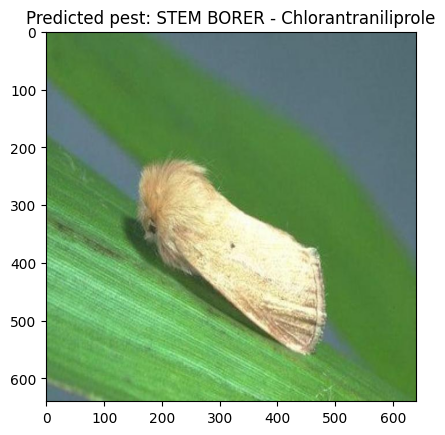

In [ ]:
# Load and preprocess the image
image_path = '/content/dataset/test/STEM BORER/sborer--106-_jpg.rf.0ec770a51c1a83ac5d8f0e5b61cec312.jpg' # Replace with your image path
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)

# Make predictions
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Print the predicted class and pest name
predicted_class = predicted.item()

# Get the pest name from the class index (assuming your classes are in the same order as in train_dataset.classes)
pest_name = train_dataset.classes[predicted_class]


print(f"Predicted pest: {pest_name}")
print(f"Predicted pesticide: {pesticide_mapping[predicted_class]}")

# Display the image
plt.imshow(Image.open(image_path))
plt.title(f"Predicted pest: {pest_name} - {pesticide_mapping[predicted_class]}")
plt.show()

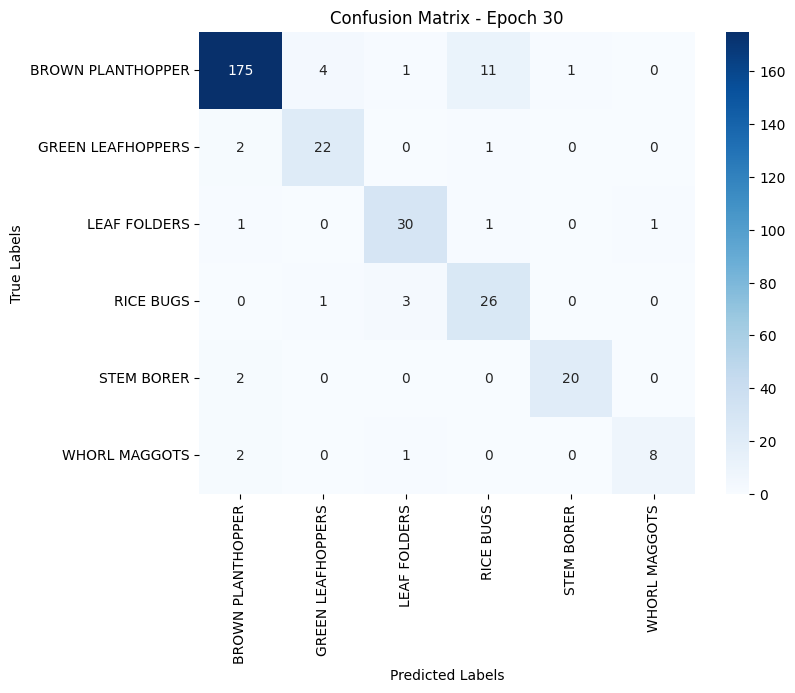

In [ ]:
# Validation phase (inside the training loop)
model.eval()
val_outputs = []
val_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_outputs.append(outputs)
        val_labels.append(labels)

# Aggregate predictions and labels for the entire validation set
val_outputs = torch.cat(val_outputs).cpu()
val_labels = torch.cat(val_labels).cpu()
_, predicted = torch.max(val_outputs, 1)

# Confusion Matrix calculation
cm = confusion_matrix(val_labels.numpy(), predicted.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title(f"Confusion Matrix - Epoch {epoch+1}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [21]:
torch.save(model.state_dict(), 'best_model_resnet34.pth')
